In [33]:
FOLDER_TEST = "exame-pulmao"
TRAIN_IMG_SRC_FOLDER = "/home/guilherme/Documents/noa/cidia19/data/output-2d/HMV/" + FOLDER_TEST
VALIDATION_IMG_SRC_FOLDER = "/home/guilherme/Documents/noa/cidia19/data/output-2d/HMV/" + FOLDER_TEST
# VALIDATION_IMG_SRC_FOLDER = "/home/guilherme/Documents/noa/cidia19/data/output-2d/HCPA/" + FOLDER_TEST

SUB_FILE = ['axis1', 'axis2']


EPOCHS = 20
IMG_HEIGHT = 300
IMG_WIDTH = 300 
IMG_CHANNELS = 3
SELECTED_MODEL = ''
NUM_CLASSES = 3
DATA_FOLDER = '20200903/'
LOG_FOLDER = 'logs/' + DATA_FOLDER
TRAINING_FOLDER = 'training/' + DATA_FOLDER
MODEL_FOLDER = 'models/' + DATA_FOLDER
IMAGE_FOLDER = 'images/' + DATA_FOLDER

STRUCTURE_DATASET_FOLDER = "csv/input/"+DATA_FOLDER


In [34]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import random

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

import glob
import os
from datetime import datetime

import tensorflow as tf

Check if there is available GPU

In [35]:
gpus = tf.config.experimental.list_physical_devices('GPU')
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [36]:
def get_file_path(folder, search_filter=''):
    '''
    Get all files (full path) contained in a PATH folder by specified search filter 
    '''
    paths = []
    for root, dirs, files in os.walk(folder):
        for file in files:
            path = os.path.join(root, file)
            if search_filter in path:
                paths.append(path)
    return paths

def get_data_set(fold_number, cur_subfile, data_train, data_test):
    ''' Creates and returns a dataframe with all the full paths (for slice) for train and test images. 
    Save it as log. 
    '''
    dfs = []
    train_images = {"id": [], "label": []}
    validation_images = {"id": [], "label": []}
    
    
    TRAIN_IMG_FOLDERS_SLICE = {}
    for _, row in data_train.iterrows():
        TRAIN_IMG_FOLDERS_SLICE[row['nome']] = row['covid']

    VALIDATION_IMG_FOLDERS_SLICE = {}
    for _, row in data_test.iterrows():
        VALIDATION_IMG_FOLDERS_SLICE[row['nome']] = row['covid']
    
    df_config = [
        (TRAIN_IMG_SRC_FOLDER, TRAIN_IMG_FOLDERS_SLICE, train_images),
        (VALIDATION_IMG_SRC_FOLDER, VALIDATION_IMG_FOLDERS_SLICE, validation_images)
    ]
    for (base, folder, dic) in df_config:
        for img_folder, img_label in folder.items():
            search_folder = "{}/{}".format(base, img_folder)
            imgs_filename = sorted(get_file_path(search_folder, search_filter = cur_subfile))
            dic["id"].extend(imgs_filename)
            dic["label"].extend([img_label] * len(imgs_filename))

        dfs.append(pd.DataFrame(data=dic))
#     print(dfs)
    train_df, validation_df = dfs[0], dfs[1]


    if not os.path.exists("logs/"): 
        os.mkdir("logs/")
    if not os.path.exists(LOG_FOLDER): 
        os.mkdir(LOG_FOLDER)
        
    train_df.to_csv("{}/train{}.csv".format(LOG_FOLDER, fold_number), index=False)
    validation_df.to_csv("{}/test{}.csv".format(LOG_FOLDER, fold_number), index=False)

    print("Train fold with {} images".format(len(train_df)))
    print(train_df.groupby("label").label.count())
    print()
    print("Validation fold with {} images".format(len(validation_df)))
    print(validation_df.groupby("label").label.count())
    print("-" * 30)
    return (train_df, validation_df)

In [37]:
def get_side(img, side_type, side_size=5):
    height, width, channel=img.shape
    if side_type=="horizontal":
        return np.ones((height,side_size,  channel), dtype=np.float32)*255
        
    return np.ones((side_size, width,  channel), dtype=np.float32)*255

def show_gallery(show="all"):
    n=100
    counter=0
    images=list()
    vertical_images=[]
    rng_state = np.random.get_state()
    np.random.shuffle(train_images["id"])
    np.random.set_state(rng_state)
    np.random.shuffle(train_images["label"])
    for path, target in zip(train_images["id"], train_images["label"]):
        if target!=show and show!="all":
            continue
        counter=counter+1
        if counter%100==0:
            break
        #Image loading from disk as JpegImageFile file format
        img=load_img(path, target_size=(IMG_WIDTH,IMG_HEIGHT))
        #Converting JpegImageFile to numpy array
        img=img_to_array(img)
        
        hside=get_side(img, side_type="horizontal")
        images.append(img)
        images.append(hside)

        if counter%10==0:
            himage=np.hstack((images))
            vside=get_side(himage, side_type="vertical")
            vertical_images.append(himage)
            vertical_images.append(vside)
            
            images=list()

    gallery=np.vstack((vertical_images)) 
    plt.figure(figsize=(12,12))
    plt.xticks([])
    plt.yticks([])
    title = {"all":"All Classifications's",
             "healthy":"Healthy",
             "covid":"Covid-19"}
    plt.title("100 Samples of {} Patients of the training set".format(title[show]))
    plt.imshow(gallery.astype(np.uint8))


In [38]:
#show_gallery("all")

In [39]:
def get_data_generator(dataframe, x_col, y_col, subset=None, shuffle=True, batch_size=32, class_mode="binary"):
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.05,
    horizontal_flip=False,
    width_shift_range=0.1,
    height_shift_range=0.1,
    )
    
    data_generator = datagen.flow_from_dataframe(
        dataframe=dataframe,
        x_col=x_col,
        y_col=y_col,
        subset=subset,
        target_size=(IMG_WIDTH, IMG_HEIGHT),
        class_mode=class_mode,
        # color_mode="rgb",
        batch_size=batch_size,
        shuffle=shuffle
    )
    return data_generator

In [40]:
def get_model_vgg16():
    with tf.device('/GPU:0'):
        conv_base = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

        conv_base.trainable = True
        set_trainable = False
        for layer in conv_base.layers:
            if layer.name == 'block1_conv1':
                set_trainable = True
            if set_trainable:
                layer.trainable = True
            else:
                layer.trainable = False

        model = tf.keras.Sequential()
        model.add(conv_base)
        model.add(tf.keras.layers.GlobalAveragePooling2D())
        model.add(tf.keras.layers.Dense(units=NUM_CLASSES, activation = 'sigmoid'))

        model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=2e-5), loss='binary_crossentropy', metrics=['accuracy'])
        model.summary()
        return (model, 'vgg16')

In [41]:
def get_model_resnet50():
    with tf.device('/GPU:0'):
        conv_base = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

        conv_base.trainable = True
#         set_trainable = False
#         for layer in conv_base.layers:
#             if layer.name == 'block1_conv1':
#                 set_trainable = True
#             if set_trainable:
#                 layer.trainable = True
#             else:
#                 layer.trainable = False

        model = tf.keras.Sequential()
        model.add(conv_base)
        model.add(tf.keras.layers.Dense(1024, activation='relu'))
        model.add(tf.keras.layers.Dense(1024, activation='relu'))
        model.add(tf.keras.layers.GlobalAveragePooling2D())
        model.add(tf.keras.layers.Dense(units=NUM_CLASSES, activation = 'sigmoid'))

        model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=2e-5), loss='binary_crossentropy', metrics=['accuracy'])
        model.summary()
        return (model, 'resnet50')

In [42]:
def train_model(model, train_df, validation_df, epochs, fold, axis):
    batch_size = 16
    train_generator = get_data_generator(train_df, "id", "label", batch_size=batch_size, class_mode="categorical")
    validation_generator = get_data_generator(validation_df, "id", "label", batch_size=batch_size, class_mode="categorical")

    print(train_generator.class_indices)
    print(validation_generator.class_indices)
    
    step_size_train = train_generator.n // train_generator.batch_size
    step_size_validation = validation_generator.n // validation_generator.batch_size

    if step_size_train == 0:
        step_size_train = train_generator.n // 2
        step_size_validation = validation_generator.n // 2
        
        
    # callbacks, save each time
    # training/20200827/vgg16/fold4/axis2
    checkpoint_path = "training/"
    if not os.path.exists("training/"): 
        os.mkdir("training/")
    checkpoint_path = "{}/".format(TRAINING_FOLDER)
    if not os.path.exists(checkpoint_path): 
        os.mkdir(checkpoint_path)
        
    checkpoint_path = "{}/{}/".format(TRAINING_FOLDER, SELECTED_MODEL)
    if not os.path.exists(checkpoint_path): 
        os.mkdir(checkpoint_path)
        
    checkpoint_path = "{}/{}/fold{}/".format(TRAINING_FOLDER, SELECTED_MODEL, fold)
    if not os.path.exists(checkpoint_path): 
        os.mkdir(checkpoint_path)
    
    checkpoint_path = "{}/{}/fold{}/{}/".format(TRAINING_FOLDER, SELECTED_MODEL, fold, axis)
    if not os.path.exists(checkpoint_path): 
        os.mkdir(checkpoint_path)
        
    # Save dict results of history and legend from current model
    # models/20200827/vgg16/fold4/axis2/{history|legend}
    if not os.path.exists("models/"): 
        os.mkdir("models/")
    
    model_dir = "{}/".format(MODEL_FOLDER)
    if not os.path.exists(model_dir): 
        os.mkdir(model_dir)
        
    model_dir = "{}/{}".format(MODEL_FOLDER, SELECTED_MODEL)
    if not os.path.exists(model_dir): 
        os.mkdir(model_dir)
        
    model_dir = "{}/{}/fold{}/".format(MODEL_FOLDER, SELECTED_MODEL, fold)
    if not os.path.exists(model_dir): 
        os.mkdir(model_dir)
    
    model_dir = "{}/{}/fold{}/{}/".format(MODEL_FOLDER, SELECTED_MODEL, fold, axis)
    if not os.path.exists(model_dir): 
        os.mkdir(model_dir)
    
    checkpoint_path = checkpoint_path + "/cp-{epoch:04d}.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)

    # Create a callback that saves the model's weights every 25 epochs
    cp_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path, 
        verbose=1, 
        save_weights_only=True,
        period=25)
        
    history = model.fit(train_generator, # X_Train
        steps_per_epoch=step_size_train,
        epochs=epochs, 
        validation_data=validation_generator,
        validation_steps=step_size_validation,
        callbacks=cp_callback
                       )
    
    # Save last values
    model.save_weights(checkpoint_dir+"/my_checkpoint")
    
    # Save history
    hist_df = pd.DataFrame(history.history) 
    hist_csv_file = model_dir + 'history.csv'
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)
    
    # Save classes
    print(train_generator.class_indices)
    np.save(model_dir + 'legend', train_generator.class_indices)
    return history.history

In [43]:

def plot_results(history, sub_folder, fold, sel_model):
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']

    
    image_dir = "images/"
    if not os.path.exists(image_dir): 
        os.mkdir(image_dir)
    
    image_dir = "{}/".format(IMAGE_FOLDER)
    if not os.path.exists(image_dir): 
        os.mkdir(image_dir)
    
    image_dir = "{}/{}/".format(IMAGE_FOLDER, SELECTED_MODEL)
    if not os.path.exists(image_dir): 
        os.mkdir(image_dir)
    
    image_dir = "{}/{}/fold{}/".format(IMAGE_FOLDER, SELECTED_MODEL, fold)
    if not os.path.exists(image_dir): 
        os.mkdir(image_dir)
    
    image_dir = "{}/{}/fold{}/{}/".format(IMAGE_FOLDER, SELECTED_MODEL, fold, axis)
    if not os.path.exists(image_dir): 
        os.mkdir(image_dir)
    
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and Validation accuracy')
    plt.legend()
    plt.savefig(image_dir + 'accuracy', pad_inches=0.1)
    
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and Validation loss')
    plt.legend()
    
    plt.savefig(image_dir + 'loss', orientation='portrait', pad_inches=0.1)

    plt.show()

Function to evaluate model for data folders (patients).

In [44]:
def predictions_by_patient(model, patients, legend_file, axis):
    results = []
    for p in patients:
        # for axis in SUB_FILE:
        curr_dir = "{}/{}/{}".format(VALIDATION_IMG_SRC_FOLDER, p, axis)
        # print(curr_dir)
        imgs_filename = sorted(os.listdir(curr_dir))
        test_filenames = imgs_filename[:]
        test_df = pd.DataFrame({
                'filename': test_filenames
            })
        nb_samples = test_df.shape[0]

        test_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
        test_generator = test_gen.flow_from_dataframe(
                test_df, 
                curr_dir, 
                x_col='filename',
                y_col=None,
                class_mode=None,
                target_size=(IMG_WIDTH, IMG_HEIGHT),
                batch_size=16,
                shuffle=False
        )

        predict = model.predict(test_generator, steps=np.ceil(nb_samples/16))
#         print(predict)
#         test_df['category'] = [int(round(p[1])) for p in predict]
        test_df['category'] = [np.where(pr == np.max(pr))[0][0] for pr in predict]
        test_df['patient'] = p
        test_df['axis'] = axis
        results.append(test_df)

    print('Axis: ', test_df['axis'][0])
    df_result = pd.DataFrame(columns=['category', 'patient','count'])
    for i,test_df in enumerate(results):
        cur_patient = test_df['patient'][0]
        if os.path.isfile(legend_file+'.npy'):
            class_indices = np.load(legend_file+'.npy', allow_pickle=True).item()
            class_indices = dict((v,k) for k,v in class_indices.items())
#             print(class_indices)
            test_df['category'] = test_df['category'].replace(class_indices)
        test_df['count'] = 1
        test_df = test_df.groupby('category', as_index = False)['count'].count()
        test_df['patient'] = cur_patient
        df_result = df_result.append(test_df)
    print(df_result)
    return df_result
        
    

Call the model for 'axis1...n' and folds [ 1...N ]




Fold 1
Train fold with 8692 images
label
INDETERMINATE    1968
NEGATIVE         1886
POSITIVE         4838
Name: label, dtype: int64

Validation fold with 2296 images
label
INDETERMINATE     492
NEGATIVE          492
POSITIVE         1312
Name: label, dtype: int64
------------------------------

axis1
=====
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 1539      
Total params: 14,716,227
Trainable params: 14,716,227
Non-trainable params: 0
_________________________________________________________________
Found 8692 validated image filenames belonging to 3 classes.

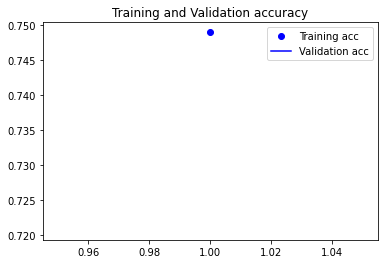

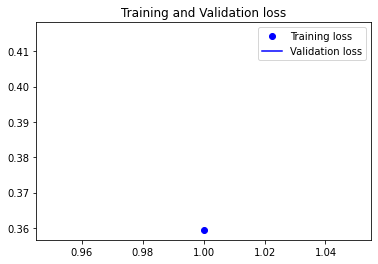

Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 164 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Axis:  axis1
        catego

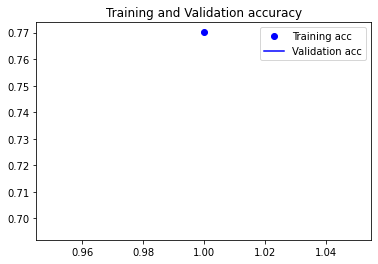

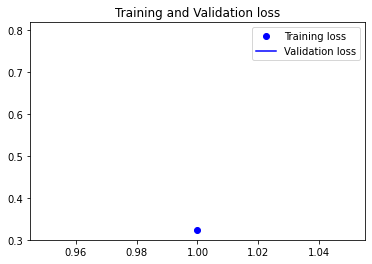

Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Axis:  axis1
        categor

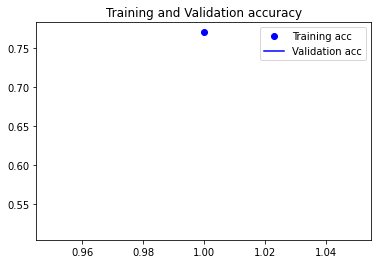

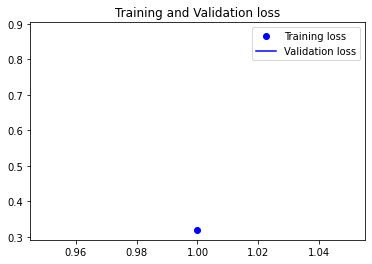

Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Axis:  axis1
        category patient count
0       NEGATIVE    

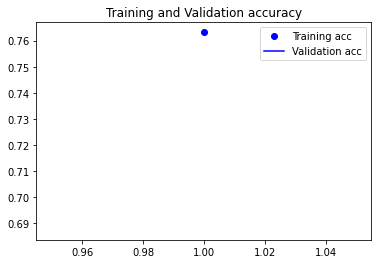

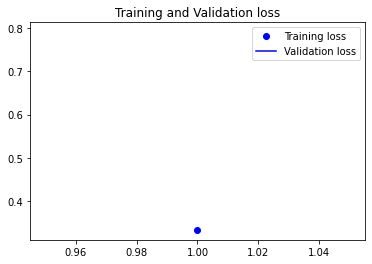

Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 164 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Axis:  axis1
        category patient count
0       NEGATIVE   

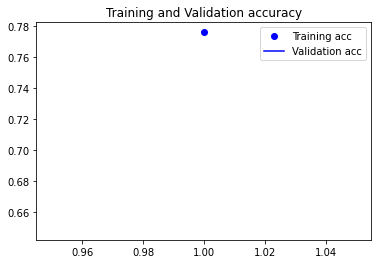

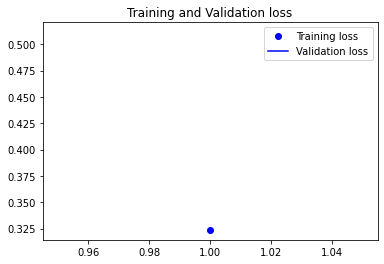

Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Axis:  axis1
        category patient count
0  INDETERMINATE    

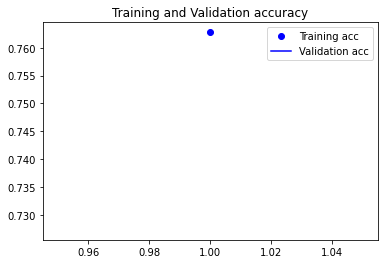

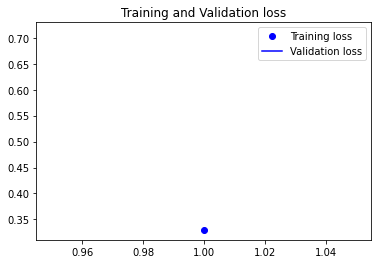

Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 164 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Axis:  axis2
        catego

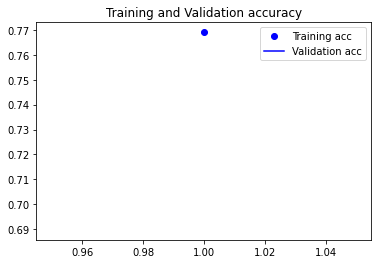

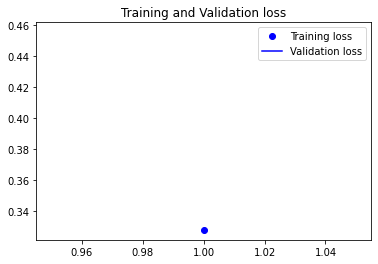

Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Axis:  axis2
        categor

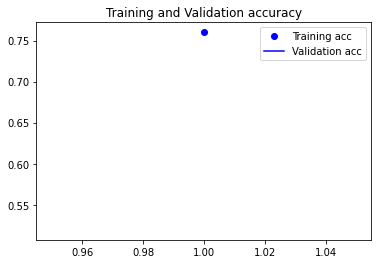

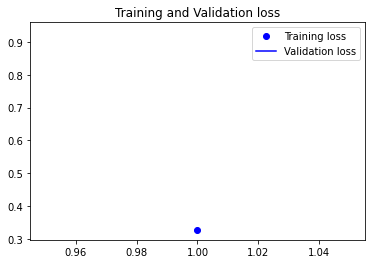

Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Axis:  axis2
        category patient count
0       NEGATIVE    

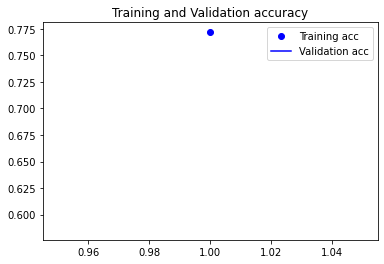

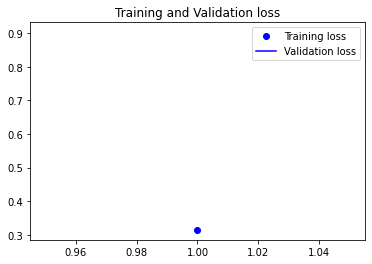

Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 164 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Axis:  axis2
        category patient count
0       NEGATIVE   

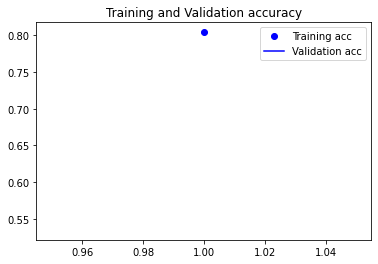

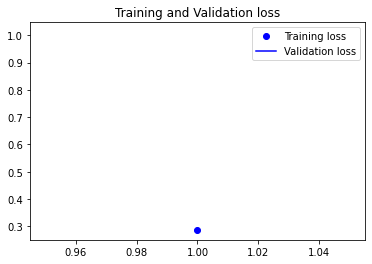

Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Axis:  axis2
        category patient count
0       NEGATIVE    

In [45]:
for axis in SUB_FILE:
    for n_fold in [1, 2, 3, 4, 5]:
        print("\n\n\nFold", str(n_fold))
        
        data_train = pd.read_csv("{}/train/train{}.csv".format(STRUCTURE_DATASET_FOLDER, n_fold))
        data_validation = pd.read_csv("{}/test/test{}.csv".format(STRUCTURE_DATASET_FOLDER, n_fold))
        train_df, validation_df = get_data_set(n_fold, axis, data_train, data_validation)
        
        print('\n'+axis+'\n=====')
        model, SELECTED_MODEL = get_model_vgg16()
#         model, SELECTED_MODEL = get_model_resnet50()
        history = train_model(model, train_df, validation_df, EPOCHS, n_fold, axis)
        
        #Plot Results
        plot_results(history, axis, n_fold, SELECTED_MODEL)
        
        # Test with other patients
        legend_path = "{}/{}/fold{}/{}/legend".format(MODEL_FOLDER, SELECTED_MODEL, n_fold, axis)
        df = predictions_by_patient(model, data_validation['nome'].to_list(), legend_path, axis)

## Check models!
Load saved model

In [ ]:
# model, SELECTED_MODEL = get_model_resnet50()
model, SELECTED_MODEL = get_model_vgg16()

# model.load_weights('training/resnet50/5fold/axis1/my_checkpoint')
fold = 1
axis = 'axis1'
legend_path = "{}/{}/fold{}/{}/legend".format(MODEL_FOLDER, SELECTED_MODEL, fold, axis)
model.load_weights("{}/{}/fold{}/{}/my_checkpoint".format(TRAINING_FOLDER, SELECTED_MODEL, fold, axis))

# data_test =  ['C77', 'C117', 'C136', 'C80', 'C91', 'C104', 'C62', 'C147', 'C106', 'C68', 'C123', 'C99', 'C129']
# HCPA
# data_test = ['NEG-001', 'NEG-002', 'NEG-003', 'NEG-004', 'NEG-005', 'NEG-006', 'NEG-007', 'NEG-008', 'NEG-009', 
#              'NEG-010', 'NEG-011', 'NEG-012', 'NEG-013', 'NEG-014', 'NEG-015', 'TYP-002', 'TYP-003', 'TYP-004', 
#              'TYP-005', 'TYP-006', 'TYP-007', 'TYP-008', 'TYP-009', 'TYP-010', 'TYP-011', 'TYP-012', 'TYP-013', 
#              'TYP-014', 'TYP-015', 'TYP-016', 'TYP-017', 'TYP-018', 'TYP-019', 'TYP-020', 'TYP-021', 'TYP-022', 
#              'TYP-023', 'TYP-024', 'TYP-025', 'TYP-026', 'TYP-027', 'TYP-028', 'TYP-029', 'TYP-030', 'TYP-031']

# HMV - CT Indeterminados - PCR Negativo
# data_test = ['C8', 'C28', 'C30', 'C31', 'C34', 'C37', 'C38', 'C45', 'C47', 'C54', 'C68', 'C72', 'C84', 'C98', 
#              'C99', 'C109', 'C119', 'C123', 'C129', 'C139', 'C140', 'C148', 'C156']

# HMV - CT Indeterminados - PCR Positivo
# data_test = ['C40', 'C48', 'C57', 'C65', 'C97', 'C107', 'C128']

# HMV - Atípicos
# data_test = ['C9', 'C43', 'C55', 'C56', 'C58', 'C59', 'C64', 'C67', 'C70', 'C73', 'C81', 'C118', 'C122', 'C127', 
#              'C134', 'C141', 'C164']

# HMV - CT Típico - PCR negativo
# data_test = ['C71', 'C101', 'C143', 'C162'] 

# HMV - CT Negativo - PCR positivo
data_test = ['C76', 'C105']

# VALIDATION_IMG_SRC_FOLDER = "/home/guilherme/Documents/noa/cidia19/data/output-2d/HCPA/exame-pulmao"
VALIDATION_IMG_SRC_FOLDER = "/home/guilherme/Documents/noa/cidia19/data/output-2d/HMV/exame-pulmao"

df = predictions_by_patient(model, data_test, legend_path, axis)

In [ ]:
df.tail(50)